In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import uproot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import awkward as ak
import h5py
import ROOT as root 
import math 

In [7]:
with h5py.File ('dataRead', 'r') as f:
    ds1 = f["jetreg"] 
    ds2 = f["signals"] 
    ds3 = f["recoPt_1"]
    ds4 = f ["l1_pt"]  
    ds5 = f["reco_eta"]
    ds6 = f["reco_phi"]
    ds7 = f["l1_jets"]
    ds8 = f["regionDivisions"]
    
    jetregions_r = ds1[:]
    signals_r = ds2[:]
    reco_Pt = ds3[:]
    l1_Pt = ds4[:]
    reco_eta = ds5[:]
    reco_phi = ds6[:]
    l1_jets = ds7[:]
    regionDivisions = ds8[:]

    

(50,)
(51,)


<BarContainer object of 50 artists>

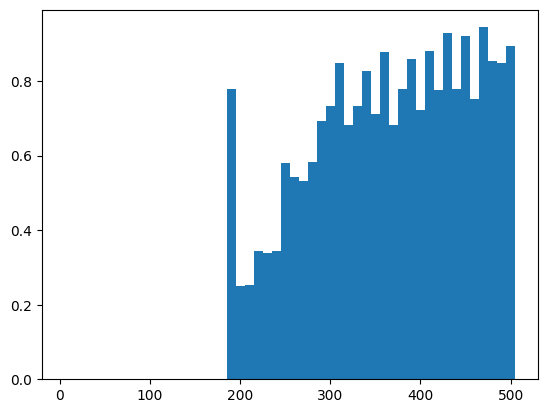

In [8]:
conditioned_recoPt = []
checking_recoPt = []  
checkL1Pt =[]

for ele in l1_Pt: 
    if ele >= 180: 
        checkL1Pt.append(ele)

#print(checkL1Pt) 
#for ele in reco_Pt: 

    #if ele != -99: 
        #checking_recoPt.append(ele)

#print (checking_recoPt) 
        
for index, element in enumerate(l1_Pt): 
    if element >= 180 : 
        conditioned_recoPt.append(reco_Pt[index]) 



a, trash= np.histogram(reco_Pt ,50, [0,500] )
b, trash2 = np.histogram(conditioned_recoPt, 50,[50, 500] ) 


#print(a)
#print(b)
ratio = np.divide(b,
                  a,
                  where=(a!= 0))

print (ratio.shape) 
print (trash.shape)
f, ax = plt.subplots(1)
ax.bar(trash[1:], ratio, np.diff(trash))

In [9]:
#plt.hist(EtFlat, 50)

In [10]:

#She makes and array of length 17859 containing 3x3 matrices called "arraya" and another array, "alabel50", shape 17859x1 of booleans. 
#Also she initializes a variablea called the aindex at 0. She uses this to keep track of the index of arraya while assigninh the arrays from 
# jetregions_[i] 

#Where did she get the value of 17859? She did from the label_r.sum where true was 1 and false 0 and she summed all the array. 

arraya = np.zeros((17859, 3, 3)) #array of all the boosted grids
alabel50= np.ones((17859))  #array of all true
aindex = 0
print(arraya.shape)

#She does the same two arrays, this time for arrays of non boosted jets and the false boolean labels (i.e non boosted). 


arrayb = np.zeros((154668-17859, 3, 3)) #array of all the non-boosted non-zero aka noise  grids
blabel50= np.zeros((154668-17859)) #array of all false
bindex = 0
print(arrayb.shape)

#if label_r[i] is true, that means that the corresponding jet, jetregions_r[i] is boosted. Add that element to arraya.  
#if label_r[i] is false, the corresponding jet is not boosted. Add that to the arrayb. 

for i in range(154668): #4590180
    if i%50000 ==0:
        print(i)
        print(aindex)
        print(bindex)

    if signals_r[i] == True:

        arraya[aindex]= jetregions_r[i] #updates data point
        aindex +=1 #updates index

    elif signals_r[i] == False:
        #print(bindex)
        arrayb[bindex]= jetregions_r[i] #updates data point
        bindex +=1 #updates index

print(aindex)
print(bindex)
print(154668-aindex)



(17859, 3, 3)
(136809, 3, 3)
0
0
0
50000
5771
44229
100000
11575
88425
150000
17332
132668
17859
136809
136809


In [11]:
percent = (aindex / (aindex+bindex))*100
print("Percentage of the set that is boosted:" , round(percent, 2))
print("the total in the set is: ", (aindex+bindex), ". training will be 80%, testing is 20%")
print("expectation: training = ", round(((aindex+bindex) *.8), 3), "; testing = ",round(((aindex+bindex) *.2), 3))


Percentage of the set that is boosted: 11.55
the total in the set is:  154668 . training will be 80%, testing is 20%
expectation: training =  123734.4 ; testing =  30933.6


In [12]:
#randomly shuffled both arraya and arrayb 

alltrue = arraya
allfalse = arrayb
np.random.shuffle(allfalse)


#now making the several different data sets for training

t1 = np.vstack((alltrue[:(round(aindex*.8))],allfalse[:(round(bindex*.8))]))  #traing set for x1 false
ts1 = np.concatenate((alabel50[:(round(aindex*.8))], blabel50[:(round(bindex*.8))]), axis=None) #traing set signals for 5050
print(t1.shape)
print(ts1.shape)


e1 = np.vstack((alltrue[(round(aindex*.8)):],allfalse[(round(bindex*.8)):]))  #traing set for x1 false
es1 = np.concatenate((alabel50[(round(aindex*.8)):], blabel50[(round(bindex*.8)):]), axis=None) #traing set signals for 5050
print(e1.shape)
print(es1.shape)






(123734, 3, 3)
(123734,)
(30934, 3, 3)
(30934,)


In [13]:
##setting the model up 



model = keras.Sequential()
model.add(layers.Conv2D(1, (3, 3),  activation='sigmoid', input_shape = (3, 3, 1)))
model.add(layers.Flatten())
print(model.summary())
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1, 1)           10        
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
Total params: 10 (40.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
# Make sure "images"  have shape (252,3,3,1)
x_train = np.expand_dims(t1, -1)
x_test = np.expand_dims(e1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = ts1
y_test = es1

#print(y_train)

x_train shape: (123734, 3, 3, 1)
123734 train samples
30934 test samples


In [15]:
class_weight = {0: 1.,
                1: 9.}

batch_size = 16
epochs = 10


hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weight,  validation_data = (x_test, y_test), verbose=0 )
print("modeling done")
score = model.evaluate(x_test, y_test, verbose=0)

modeling done


In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#X, y = make_classification(n_samples=80000) , x is the data, y is the label

alltrue1 = arraya
allfalse1 = arrayb
np.random.shuffle(alltrue1)
np.random.shuffle(allfalse1)

alldata = np.vstack((alltrue[:(round(aindex*.8))],allfalse[:(round(bindex*.8))]))  #traing set for x1 false
allsig = np.concatenate((alabel50[:(round(aindex*.8))], blabel50[:(round(bindex*.8))]), axis=None) #traing set signals for 5050
print(alldata.shape)
print(allsig.shape)


X_train, X_test, y_train, y_test = train_test_split(alldata, allsig, test_size=0.5)


print(X_test.shape)
print(y_test.shape)
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

print(X_train.shape)
print(y_train.shape)




(123734, 3, 3)
(123734,)
(61867, 3, 3)
(61867,)
(30933, 3, 3)
(30933,)


In [17]:

from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(layers.Conv2D(1, (3, 3),  activation='sigmoid', input_shape = (3, 3, 1)))
    model.add(layers.Flatten())
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.add(Dense(20, input_dim=20, activation='relu'))
    #model.add(Dense(40, activation='relu'))
    #model.add(Dense(1, activation='sigmoid'))
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

keras_model = build_model()
class_weight = {0: 1.,
                1: 50.,}
keras_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, class_weight=class_weight)

Epoch 1/10
1934/1934 [==============================] - 1s 348us/step - loss: 19.6718 - accuracy: 0.2625
Epoch 2/10
1934/1934 [==============================] - 1s 342us/step - loss: 5.8138 - accuracy: 0.2375
Epoch 3/10
1934/1934 [==============================] - 1s 349us/step - loss: 2.5882 - accuracy: 0.2262
Epoch 4/10
1934/1934 [==============================] - 1s 343us/step - loss: 2.5149 - accuracy: 0.1546
Epoch 5/10
1934/1934 [==============================] - 1s 342us/step - loss: 2.5136 - accuracy: 0.1207
Epoch 6/10
1934/1934 [==============================] - 1s 342us/step - loss: 2.5009 - accuracy: 0.1201
Epoch 7/10
1934/1934 [==============================] - 1s 340us/step - loss: 2.4923 - accuracy: 0.1200
Epoch 8/10
1934/1934 [==============================] - 1s 341us/step - loss: 2.4959 - accuracy: 0.1213
Epoch 9/10
1934/1934 [==============================] - 1s 342us/step - loss: 2.5013 - accuracy: 0.1202
Epoch 10/10
1934/1934 [==============================] - 1s 343

In [18]:

from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)


1934/1934 [==============================] - 0s 217us/step


In [19]:
#print(y_pred_keras)
#print(y_pred_keras.shape) 
print(tpr_keras[230])

#print(thresholds_keras.shape )

0.017546342153671998


In [20]:

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.7061462911300493


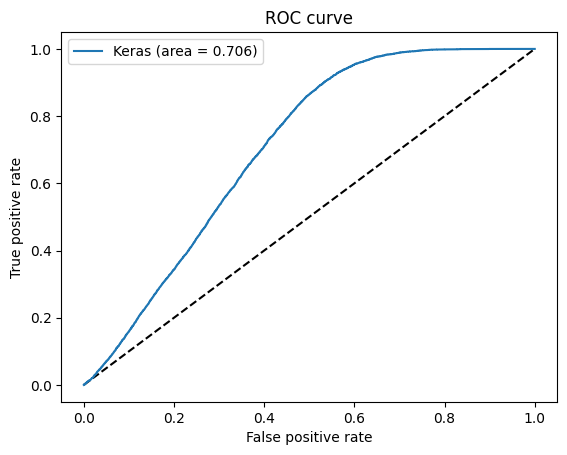

In [21]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

1934/1934 [==============================] - 0s 218us/step


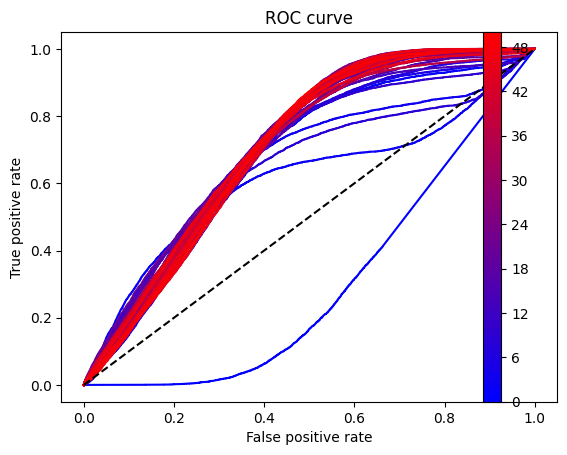

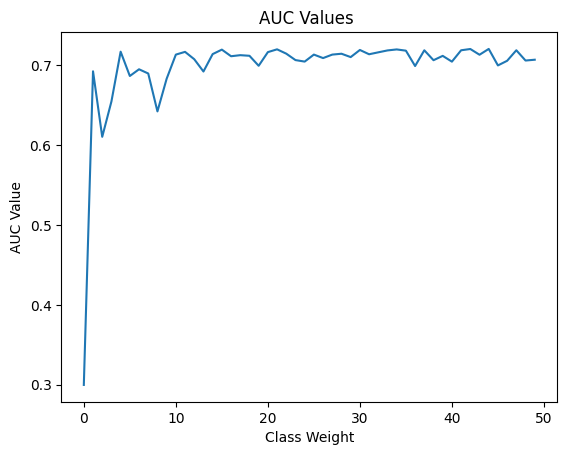

The best AUC was found at [44] with a value of 0.72


In [22]:
import matplotlib
#X, y = make_classification(n_samples=80000) , x is the data, y is the label
aucvals = np.ones((50))
min, max = (0, 50)
step = 1

# Setting up a colormap that's a simple transtion
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

plt.figure(1)


for t in range(50):
    alltrue1 = arraya
    allfalse1 = arrayb
    np.random.shuffle(alltrue1)
    np.random.shuffle(allfalse1)

    alldata = np.vstack((alltrue[:(round(aindex*.8))],allfalse[:(round(bindex*.8))]))  #traing set for x1 false
    allsig = np.concatenate((alabel50[:(round(aindex*.8))], blabel50[:(round(bindex*.8))]), axis=None) #traing set signals for 5050



    X_train, X_test, y_train, y_test = train_test_split(alldata, allsig, test_size=0.5)


    X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                                y_train,
                                                                test_size=0.5)

    keras_model = build_model()
    class_weight = {0: 1.,
                    1: t,}
    keras_model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0, class_weight=class_weight)


    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    aucvals[t]= auc_keras
    r = (float(t)-min)/(max-min)
    g = 0
    b = 1-r
    plt.plot(fpr_keras, tpr_keras,color=(r,g,b))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.colorbar(CS3)
plt.show()
    
plt.plot(np.arange(50),aucvals)
plt.xlabel('Class Weight')
plt.ylabel('AUC Value')
plt.title('AUC Values ')
plt.show()

print("The best AUC was found at", np.where(aucvals == np.max(aucvals))[0], "with a value of", round(np.max(aucvals),3) )



2417/2417 [==============================] - 1s 214us/step


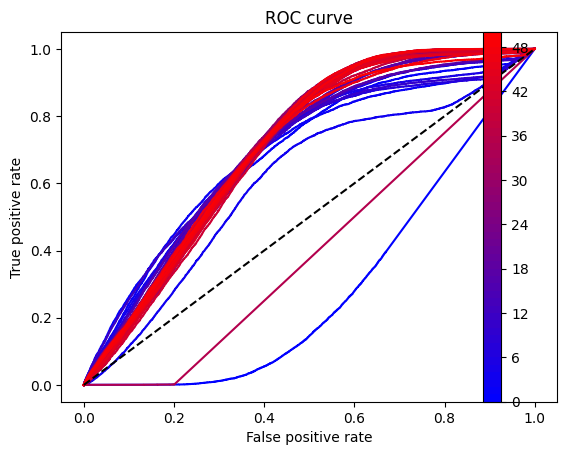

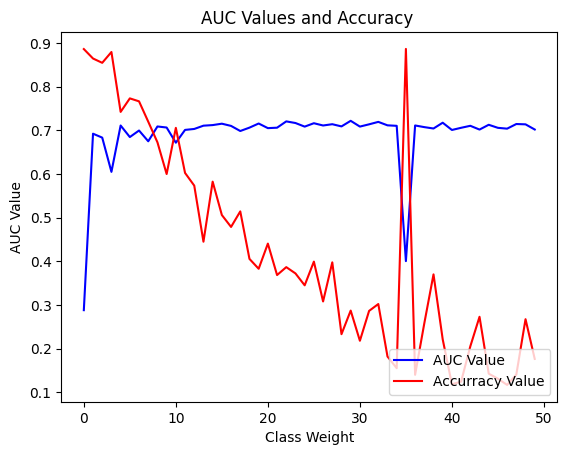

The best AUC was found at [29] with a value of 0.722


In [23]:
#X, y = make_classification(n_samples=80000) , x is the data, y is the label
aucvals = np.ones((50))
accuracyvals= np.ones((50))
min, max = (0, 50)
step = 1

# Setting up a colormap that's a simple transtion
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

plt.figure(1)


for t in range(50):
    alltrue1 = arraya
    allfalse1 = arrayb

    alldata = np.vstack((alltrue[:],allfalse[:]))  #traing set for x1 false
    allsig = np.concatenate((alabel50[:], blabel50[:]), axis=None) #traing set signals for 5050




    X_train, X_test, y_train, y_test = train_test_split(alldata, allsig, test_size=0.5)


    X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                                y_train,
                                                                test_size=0.5)

    keras_model = build_model()
    class_weight = {0: 1.,
                    1: t,}
    keras_model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0, class_weight=class_weight)


    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    aucvals[t]= auc_keras
    score = keras_model.evaluate(X_test, y_test, verbose=0)
    accuracyvals[t] = score[1] 
    
    r = (float(t)-min)/(max-min)
    g = 0
    b = 1-r
    plt.plot(fpr_keras, tpr_keras,color=(r,g,b))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.colorbar(CS3)
plt.show()
    
plt.plot(np.arange(50),aucvals, label = 'AUC Value', c = 'b')
plt.plot(np.arange(50),accuracyvals, label = 'Accurracy Value', c = 'r')
plt.legend(loc='lower right', fontsize='10')

plt.xlabel('Class Weight')
plt.ylabel('AUC Value')
plt.title('AUC Values and Accuracy ')
plt.show()

print("The best AUC was found at", np.where(aucvals == np.max(aucvals))[0], "with a value of", round(np.max(aucvals),3) )



In [24]:
#This is the model that im gonna use for the predictions 

scores =  keras_model.predict(jetregions_r).ravel()

#print(y_pred_keras.shape)
#print(X_test.shape) 
#print(scores) 


4834/4834 [==============================] - 1s 214us/step


In [33]:
l1_jets_resized = []

for ele in (l1_jets):
    placeholder = []
    
    for i in range(3):
        placeholder.append(ele[0][i])
        
    placeholder.append(ele[1])
    l1_jets_resized.append(placeholder)
   
vLorentz = [] 
for ele in (l1_jets_resized):

    Lorentz = root.TLorentzVector()

    Lorentz.SetPxPyPzE(ele[0],ele[1], ele[2], ele[3])

    vLorentz.append(Lorentz)
     
LorentzVectors = np.array(vLorentz)

print (LorentzVectors.shape) 

 

(154668,)


Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cnvs


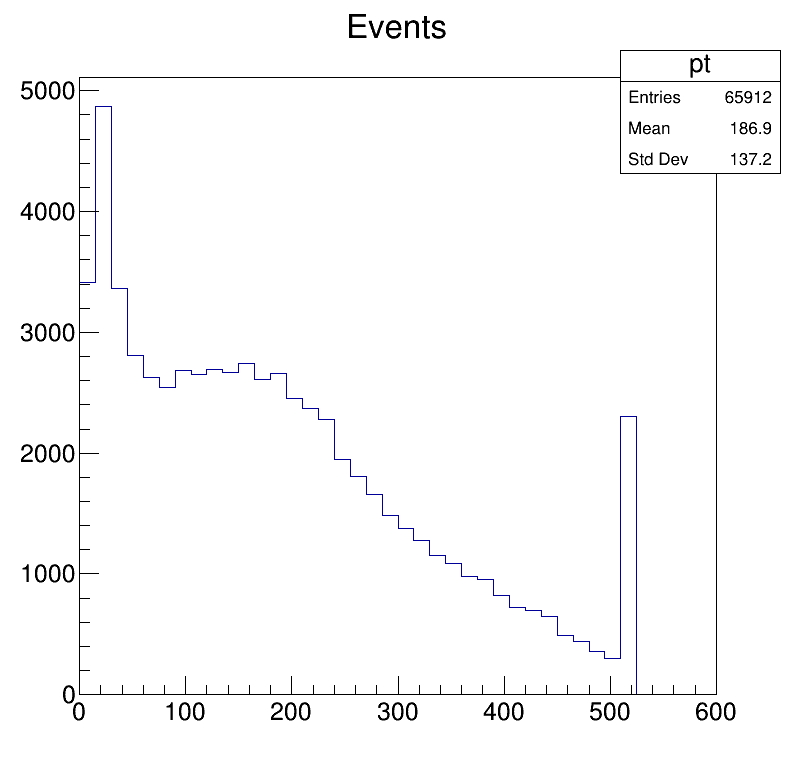

In [36]:

#The tracker variable is for indexing through the arrays with 154668 entries (like the scores, jetRegionsET, and l1_jets arrays) 
tracker = 0
#The reco_index is for indexing through the recoEta_1 and recoPhi_1 arrays. 
reco_index = -1

#iterate through the elements of the regionDivisions array, which contain the size of each region for scores, jetRegionsEt and l1_jets arrays. 
#jetRegionsEt and l1jets where flattened and resized to be converted into np.arrays, but before that they were divided into regions. 
#the regionDivisions array has as its elements int numbers that correspond to how many elements of the aforementioned array 
# belong to the 1st region, the second and so on. 

#An array of the min deltaR^2 of every region
deltaR_array = [] 

#keeps track of the pt for the min deltaR^2, and the array where to store them

new_L1Pt = []
#hs1  = root.TH1F("pt", "Events", 40, 0, 600) 

for ele in regionDivisions: 
    
    pt_tracker = 0 
    reco_index += 1 
    deltaR_squared_min = float(99) 
    if (reco_eta[reco_index] > - 5 ):
    #We define this variable to keep track of what deltaR^2 is the smallest one in that region chosen. 
       
    
    # This index will go through the values in the scores and l1jets arrays that correspond to the same regions, as determined by regionDivisions
        for index in range(tracker,tracker + ele):
        
        #choose only to analyze the scores that are predicted to be greater than 0.5 
           # print(scores[index]) 
            if scores[index] > 0.5:
            
         
            #Convert the l1jets info into a lorentz vector root object. 
                Jet_LorentzVector = LorentzVectors[index]
                #print(l1_jets[index]) 
                #print(Jet_LorentzVector)
               # if Jet_LorentzVector.Pt() > 0 : 
                    #hs1.Fill(Jet_LorentzVector.Pt())
                
                #print(Jet_LorentzVector.Eta())
                #print("\n")
                
            #calculate deltaR^2 for the elements in the region. In here, the recoEta and recoPhi values stay fixed for the corresponding 
            #regionDivision's element. There is a  1:1 correspondence between the regionDivisions and recoEta/Phi arrays. 
            
                deltaR_squared = (Jet_LorentzVector.Eta() -reco_eta[reco_index])**2 + (Jet_LorentzVector.Phi() - reco_phi[reco_index])**2
                #print(reco_eta[reco_index])
                #print(deltaR_squared)
                
            
            #Keep the smallest R^2 for the region
                if deltaR_squared < deltaR_squared_min: 
                    deltaR_squared_min = deltaR_squared
                #print(deltaR_min)
                    pt_tracker = Jet_LorentzVector.Pt()
                    #print(pt_tracker)
                   # print ("\n")
                    
        #print(deltaR_min)
    deltaR_min = math.sqrt(deltaR_squared_min)
    deltaR_array.append(deltaR_min)
    new_L1Pt.append(pt_tracker) 
    
    tracker += ele 

dR_min = np.array(deltaR_array)

#cnvs = root.TCanvas("cnvs", "canvas", 800, 800)
#hs1.SetFillColor(0)
#hs1.Draw()
#cnvs.Draw()
#print(new_l1pt.shape)
#print(new_l1pt)   




#print(np.count_nonzero(np.isinf(new_l1pt)))
#print(np.count_nonzero(np.any(scores < 0.5)))

Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cnvs


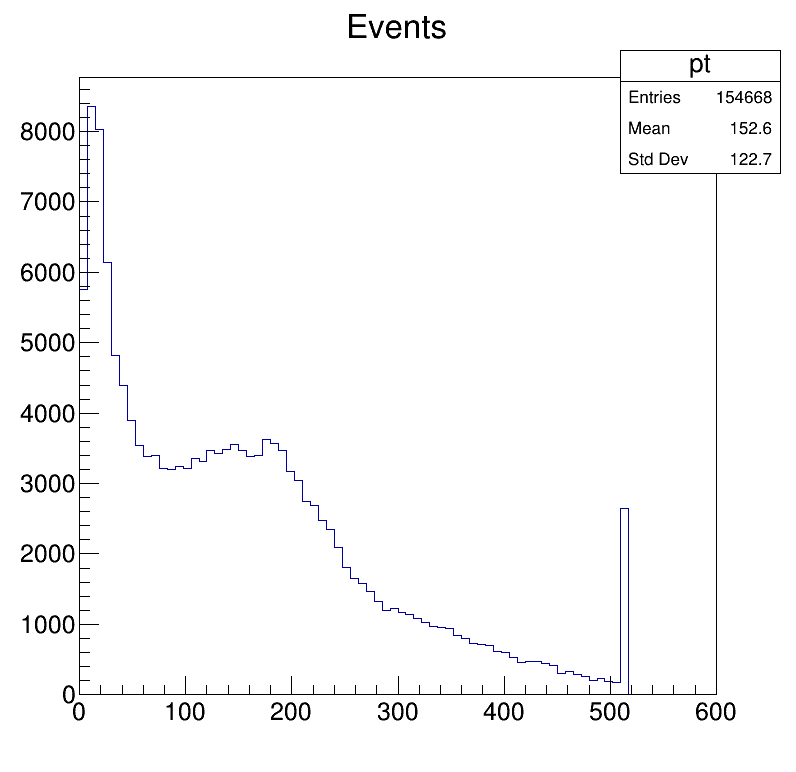

In [46]:
hs1  = root.TH1F("pt", "Events", 80, 0, 600) 

for ele in LorentzVectors: 
    hs1.Fill(ele.Pt())


cnvs = root.TCanvas("cnvs", "canvas", 800, 800)
hs1.SetFillColor(0)
hs1.Draw()
cnvs.Draw()

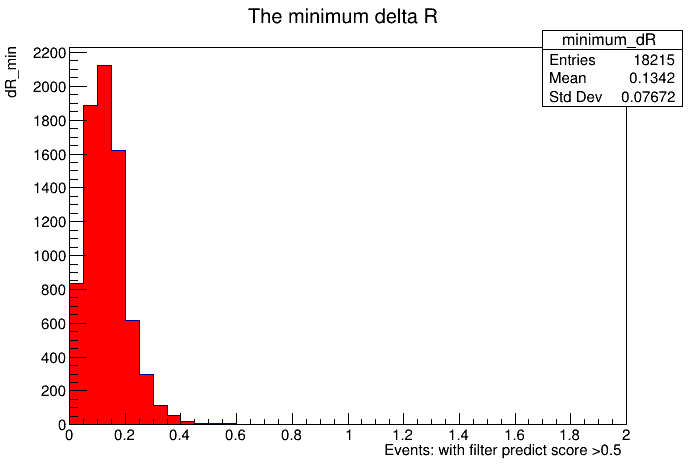

In [47]:
#print(scores[49]) 

deltaR_hist = root.TH1F("minimum_dR ", "The minimum delta R; Events: with filter predict score >0.5 ; dR_min", 40, 0, 2 ) 

for value in dR_min: 
    deltaR_hist.Fill(value)

deltaR_hist.SetFillColor(2) 

Tcan = root.TCanvas()
deltaR_hist.Draw()

Tcan.Draw()



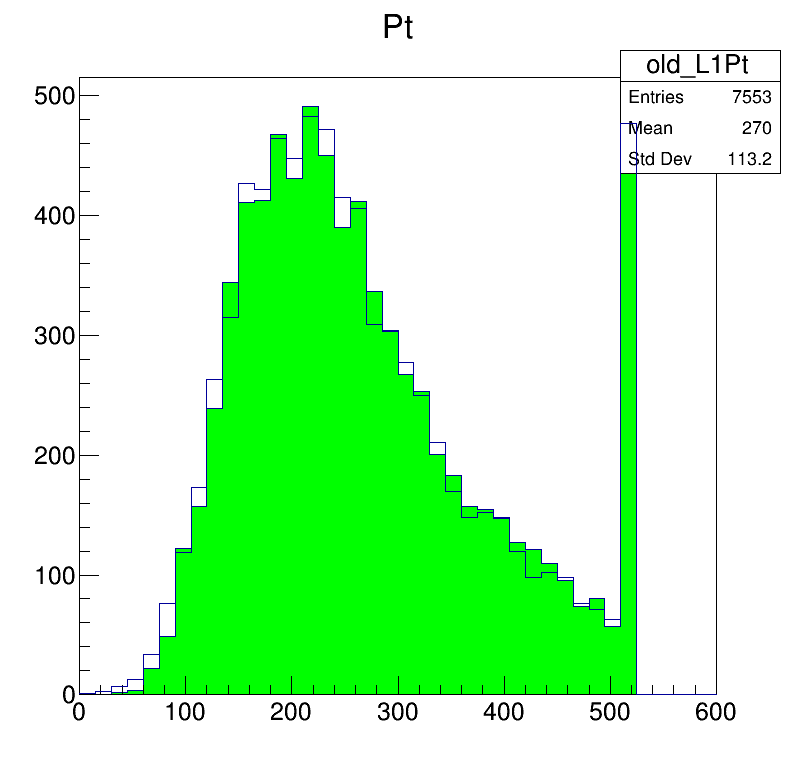

In [48]:
new_L1Pt_hist = root.TH1F("new_L1Pt", "Pt from the chosen deltaR^2_min ; Events: with filter predict score > 0,5 ; Pt " , 40, 0 ,600) 

for pt in new_L1Pt:
    if pt > 0: 
        #print(pt)
        new_L1Pt_hist.Fill(pt) 
#
new_L1Pt_hist.SetFillColor(0) 



old_l1pt_hist = root.TH1F("old_L1Pt" , "Pt", 40, 0 ,600)  

for pt in l1_Pt: 
    if pt > 0:
        #print(pt) 
        old_l1pt_hist.Fill(pt)

old_l1pt_hist.SetFillColor(3) 

canvas = root.TCanvas("Tcanvas", "Canvas", 800, 800)
old_l1pt_hist.Draw()
new_L1Pt_hist.Draw("same")
canvas.Draw()
    

Warning in <TROOT::Append>: Replacing existing TH1: passed_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: total_hist (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cnvs


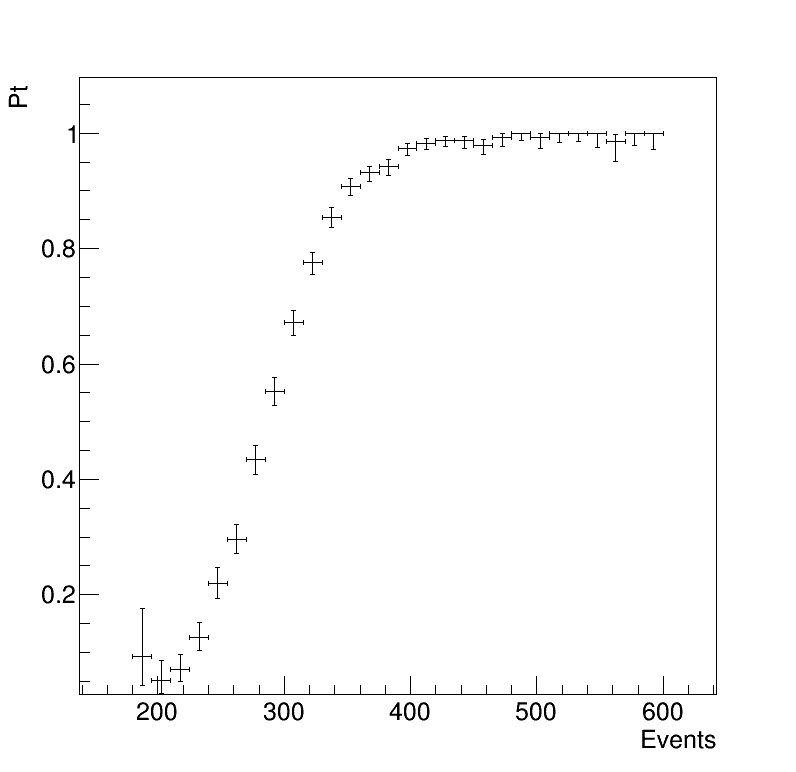

In [101]:
#This is the efficiency plot. It has the threshold of pt>180 for then numerator. 



conditions_pt = []
passed_hist = root.TH1F ("passed_hist", "Pt with the 180 min cut  ; Events; Pt " , 40, 0 ,600) 
total_hist = root.TH1F ("total_hist", "Pt: total; Events; Pt " , 40, 0 ,600)

for pt in new_L1Pt: 

    if pt > 180: 
        conditions_pt.append(True)
        
    else: {conditions_pt.append(False)}

for pt in reco_Pt: 

    if pt > 0 : 
        total_hist.Fill(pt)

for pt in reco_Pt[conditions_pt]:

    #print(pt)
    passed_hist.Fill(pt)



#print(reco_Pt[conditions_pt][0])

#print(reco_Pt[])
eff = root.TEfficiency(passed_hist, total_hist)
#
cnvs = root.TCanvas("cnvs", "canvas", 800, 800)
eff.Draw()
cnvs.Draw()

#print(len(reco_Pt))
#print(len(new_L1Pt))
#eff = root.TEfficiency() 

In [ ]:
    
plt.plot(np.arange(50),aucvals, label = 'AUC Value', c = 'b')
plt.plot(np.arange(50),accuracyvals, label = 'Accurracy Value', c = 'r')
plt.legend(loc='lower right', fontsize='10')

plt.xlabel('Class Weight')
plt.ylabel('AUC Value')
plt.title('AUC Values and Accuracy ')
plt.show()

print("The best AUC was found at", np.where(aucvals == np.max(aucvals))[0], "with a value of", round(np.max(aucvals),3) )


In [ ]:
#X, y = make_classification(n_samples=80000) , x is the data, y is the label
aucvals = np.ones((20))
accuracyvals= np.ones((20))

plt.figure(1)


for t in range(20):
    alltrue1 = arraya
    allfalse1 = arrayb

    alldata = np.vstack((alltrue[:],allfalse[:]))  #traing set for x1 false
    allsig = np.concatenate((alabel50[:], blabel50[:]), axis=None) #traing set signals for 5050



    X_train, X_test, y_train, y_test = train_test_split(alldata, allsig, test_size=0.5)


    X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                                y_train,
                                                                test_size=0.5)

    keras_model = build_model()
    class_weight = {0: 1.,
                    1: t,}
    keras_model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0, class_weight=class_weight)


    y_pred_keras = keras_model.predict(X_test).ravel()

    score = keras_model.evaluate(X_test, y_test, verbose=0)
    accuracyvals[t] = score[1] 
    

   
    
#plt.plot(np.arange(50),aucvals, label = 'AUC Value', c = 'b')
#plt.plot(np.arange(50),accuracyvals, label = 'Accurracy Value', c = 'r')
#plt.legend(loc='lower right', fontsize='10')

#plt.xlabel('Class Weight')
#plt.ylabel('AUC Value')
#plt.title('AUC Values and Accuracy ')
#plt.show()

print("The best AUC was found at", np.where(aucvals == np.max(aucvals))[0], "with a value of", round(np.max(aucvals),3) )



In [ ]:
I have to leave and go and never come back and I have changed a lot and that isnt going to last forever change of scene change of weather trials UI may have to weather I dont care call whenever u need helpo whatsoever forever and ever 

# 